In [1]:
def jaccard_similarity(interval_a, interval_b):
    # Lấy khoảng giao của hai đoạn
    intersection = max(0, min(interval_a[1], interval_b[1]) - max(interval_a[0], interval_b[0]))
    # Lấy khoảng hợp của hai đoạn
    union = (interval_a[1] - interval_a[0]) + (interval_b[1] - interval_b[0]) - intersection
    # Tính Jaccard Similarity
    return intersection / union if union > 0 else 0

# Độ dài của các đoạn cần so sánh (ví dụ, 10 giây)
# chunk_duration = 10
# video_length = 120  # giả sử video có độ dài 120 giây
# num_chunks = video_length // chunk_duration

# # Tính Jaccard Similarity cho mỗi đoạn và trung bình tất cả
# jaccard_scores = []
# for i in range(num_chunks):
#     # Đoạn tương ứng trong video tóm tắt và video ground truth
#     interval_a = [i * chunk_duration, (i + 1) * chunk_duration]
#     interval_b = [i * chunk_duration, (i + 1) * chunk_duration]
    
#     # Tính Jaccard Similarity
#     score = jaccard_similarity(interval_a, interval_b)
#     jaccard_scores.append(score)

# # Tính Jaccard trung bình
# average_jaccard_similarity = sum(jaccard_scores) / len(jaccard_scores)
# print("Average Jaccard Similarity:", average_jaccard_similarity)


Average Jaccard Similarity: 1.0


In [10]:
import pandas as pd
import numpy as np
merged = pd.read_csv("../data/sample_tv360/video_chunk/audio_based_scenes.csv")
merged['intersection'] = np.maximum(0, np.minimum(merged['data_end'], merged['gt_end']) - np.maximum(merged['data_start'], merged['gt_start']))
merged['full'] = (merged['data_end'] -merged['data_start']) +(- merged['gt_start'] + merged['gt_end']) - merged['intersection']
merged['jarcard'] = merged['intersection']/merged['full']

import numpy
numpy.average(merged['jarcard'])
# merged[['data_start', 'data_end', 'gt_start', 'gt_end']]

0.29104800433695066

In [21]:
import cv2
import numpy as np
import torch
from torchvision import models, transforms
from transformers import ViTFeatureExtractor, ViTModel
import clip
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Khởi tạo mô hình ResNet50
resnet_model = models.resnet50(pretrained=True)
resnet_model.eval()

inception_model = models.inception_v3(pretrained=True)
inception_model.eval()

# Khởi tạo mô hình CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device="cuda")  # hoặc 'cuda' nếu có GPU

# Khởi tạo mô hình ViT
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to('cuda')
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

preprocess = transforms.Compose([
    transforms.Resize(299),  # Inception v3 yêu cầu kích thước đầu vào 299x299
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_inception_embedding(frame):
    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = preprocess(frame_pil).unsqueeze(0)  # Chuyển tensor sang GPU nếu có
    with torch.no_grad():
        embedding = inception_model(input_tensor)
    return embedding.squeeze().cpu().numpy()

# Hàm trích xuất embedding cho một frame với ResNet
def get_resnet_embedding(frame):
    
    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = preprocess(frame_pil).unsqueeze(0)
    with torch.no_grad():
        embedding = resnet_model(input_tensor)
    return embedding.squeeze().numpy()

# Hàm trích xuất embedding cho một frame với CLIP
def get_clip_embedding(frame):
    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = clip_preprocess(frame_pil).unsqueeze(0).to('cuda')
    with torch.no_grad():
        embedding = clip_model.encode_image(input_tensor).cpu().numpy().squeeze()
    return embedding

# Hàm trích xuất embedding cho một frame với ViT
def get_vit_embedding(frame):
    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    inputs = vit_feature_extractor(images=frame_pil, return_tensors="pt").to('cuda')
    with torch.no_grad():
        outputs = vit_model(**inputs)
    return outputs.pooler_output.squeeze().cpu().numpy()

# Hàm để tính trung bình embedding cho toàn bộ video
def get_video_embedding(video_path, model_type='resnet', method = 'concat'):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    num_frames=30
    if frame_count < num_frames:
        print(f"Warning: Video {video_path} has fewer than {num_frames} frames, using available {frame_count} frames.")
        frame_indices = np.linspace(0, frame_count - 1, frame_count, dtype=int)
    else:
        frame_indices = np.linspace(0, frame_count - 1, num_frames, dtype=int)

    embeddings = []
    for idx in tqdm(frame_indices, desc="Extracting frame embeddings"):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        if model_type == 'resnet':
            embedding = get_resnet_embedding(frame)
        elif model_type == 'clip':
            embedding = get_clip_embedding(frame)
        elif model_type == 'vit':
            embedding = get_vit_embedding(frame)
        elif model_type == 'inception':
            embedding = get_inception_embedding(frame)
        else:
            raise ValueError("Model type không hợp lệ. Chọn 'resnet', 'clip', 'vit', hoặc 'inception'.")

        embeddings.append(embedding)

    cap.release()
    
    if len(embeddings) != num_frames:
        print(f"Warning: Video {video_path} không có đủ {num_frames} frame, chỉ có {len(embeddings)} frame.")
        return np.nan
    
    # Tính trung bình embedding để tạo thành vector duy nhất
    if method == 'mean':
        video_embedding = np.mean(embeddings, axis=0)
    elif method == 'concat':
        video_embedding = np.concatenate(embeddings)
        
    if np.isnan(video_embedding).any():
        print(f"Embedding contains NaN for video: {video_path}")
        return np.nan

    return video_embedding

# Tính toán Cosine Similarity giữa hai video
def compare_videos(video1_path, video2_path, model_type='resnet'):
    embedding1 = get_video_embedding(video1_path, model_type)
    embedding2 = get_video_embedding(video2_path, model_type)
    
    # Kiểm tra nếu embedding chứa NaN
    if np.isnan(embedding1).any() or np.isnan(embedding2).any():
        print(f"Embedding contains NaN for videos: {video1_path}, {video2_path}")
        return np.nan  # Hoặc giá trị khác phù hợp

    cosine_sim = cosine_similarity([embedding1], [embedding2])[0][0]
    # print(f"Cosine Similarity giữa hai video sử dụng {model_type.upper()}:", cosine_sim)
    return cosine_sim

In [22]:
import os
from tqdm import tqdm
root_gt = "../data/sample_tv360/gt"
root_data = "../data/sample_tv360/do_merge"

sorted_gt = sorted([x for x in os.listdir('../data/sample_tv360/gt') if 'based_audio' in x], key=lambda x: int(x.split("_")[3]))
sorted_data = sorted([x for x in os.listdir("../data/sample_tv360/do_merge")if 'based_audio' in x], key = lambda x: int(x.split("_")[-1].split(".")[0]))

In [23]:
resnet_cs, inception_cs, vit_cs, clip_cs = [], [], [], []
for i, j in tqdm(zip(sorted_gt, sorted_data)):
    print("Đây là ", i, "và", j)
    resnet = compare_videos(f"{root_gt}/{i}", f"{root_data}/{j}", model_type='resnet')
    resnet_cs.append(resnet)
    inception = compare_videos(f"{root_gt}/{i}", f"{root_data}/{j}", model_type='inception')
    inception_cs.append(inception)
    vit = compare_videos(f"{root_gt}/{i}", f"{root_data}/{j}", model_type='vit')
    vit_cs.append(vit)
    clip = compare_videos(f"{root_gt}/{i}", f"{root_data}/{j}", model_type='clip')
    clip_cs.append(clip)

print("Đây là kết quả cosine dựa trên độ đo RESNET", np.average(resnet_cs))
print("Đây là kết quả cosine dựa trên độ đo Inception", np.average(inception_cs))
print("Đây là kết quả cosine dựa trên độ đo ViT", np.average(vit_cs))
print("Đây là kết quả cosine dựa trên độ đo CLIP", np.average(clip_cs))


0it [00:00, ?it/s]

Đây là  chunk_based_audio_1_gt.mp4 và merged_video_based_audio_p_1.mp4


Extracting frame embeddings: 100%|██████████| 30/30 [00:00<00:00, 37.21it/s]
1it [00:13, 13.45s/it]

Đây là  chunk_based_audio_2_gt.mp4 và merged_video_based_audio_p_2.mp4


Extracting frame embeddings: 100%|██████████| 30/30 [00:00<00:00, 37.42it/s]
2it [00:26, 13.03s/it]

Đây là  chunk_based_audio_3_gt.mp4 và merged_video_based_audio_p_3.mp4


Extracting frame embeddings: 100%|██████████| 30/30 [00:00<00:00, 39.54it/s]
3it [00:38, 12.59s/it]

Đây là  chunk_based_audio_4_gt.mp4 và merged_video_based_audio_p_4.mp4


Extracting frame embeddings: 100%|██████████| 30/30 [00:00<00:00, 41.98it/s]
4it [00:50, 12.62s/it]

Đây là  chunk_based_audio_5_gt.mp4 và merged_video_based_audio_p_5.mp4


Extracting frame embeddings: 100%|██████████| 30/30 [00:00<00:00, 36.02it/s]
5it [01:03, 12.59s/it]

Đây là  chunk_based_audio_6_gt.mp4 và merged_video_based_audio_p_6.mp4


Extracting frame embeddings: 100%|██████████| 30/30 [00:00<00:00, 36.27it/s]
6it [01:15, 12.54s/it]

Đây là  chunk_based_audio_7_gt.mp4 và merged_video_based_audio_p_7.mp4


Extracting frame embeddings: 100%|██████████| 30/30 [00:00<00:00, 38.12it/s]
7it [01:28, 12.52s/it]

Đây là  chunk_based_audio_8_gt.mp4 và merged_video_based_audio_p_8.mp4


Extracting frame embeddings: 100%|██████████| 30/30 [00:00<00:00, 37.27it/s]
8it [01:41, 12.62s/it]

Đây là  chunk_based_audio_9_gt.mp4 và merged_video_based_audio_p_9.mp4


Extracting frame embeddings: 100%|██████████| 30/30 [00:00<00:00, 37.45it/s]
9it [01:53, 12.66s/it]

Đây là  chunk_based_audio_10_gt.mp4 và merged_video_based_audio_p_10.mp4


Extracting frame embeddings: 100%|██████████| 30/30 [00:00<00:00, 36.72it/s]
10it [02:06, 12.63s/it]

Đây là kết quả cosine dựa trên độ đo RESNET 0.64855117
Đây là kết quả cosine dựa trên độ đo Inception 0.41564545
Đây là kết quả cosine dựa trên độ đo ViT 0.7126459
Đây là kết quả cosine dựa trên độ đo CLIP 0.7929324363654724


  0%|          | 0/4 [00:00<?, ?it/s]















Extracting frame embeddings: 100%|██████████| 30/30 [00:02<00:00, 12.69it/s]
















Extracting frame embeddings: 100%|██████████| 30/30 [00:02<00:00, 13.35it/s]
















Extracting frame embeddings: 100%|██████████| 30/30 [00:02<00:00, 12.73it/s]
















Extracting frame embeddings: 100%|██████████| 30/30 [00:02<00:00, 14.85it/s]
















Extracting frame embeddings: 100%|██████████| 30/30 [00:02<00:00, 13.39it/s]
















Extracting frame embeddings: 100%|██████████| 30/30 [00:02<00:00, 12.99it/s]
















Extracting frame embeddings: 100%|██████████| 30/30 [00:02<00:00, 12.62it/s]
















Extracting frame embeddings: 100%|██████████| 30/30 [00:02<00:00, 12.82it/s]
















Extracting frame embeddings: 100%|██████████| 30/30 [00:02<00:00, 13.48it/s]
















Extracting frame embeddings: 100%|██████████| 30/30 [00:02<00:00, 12.20it/s]
















Extracting frame 

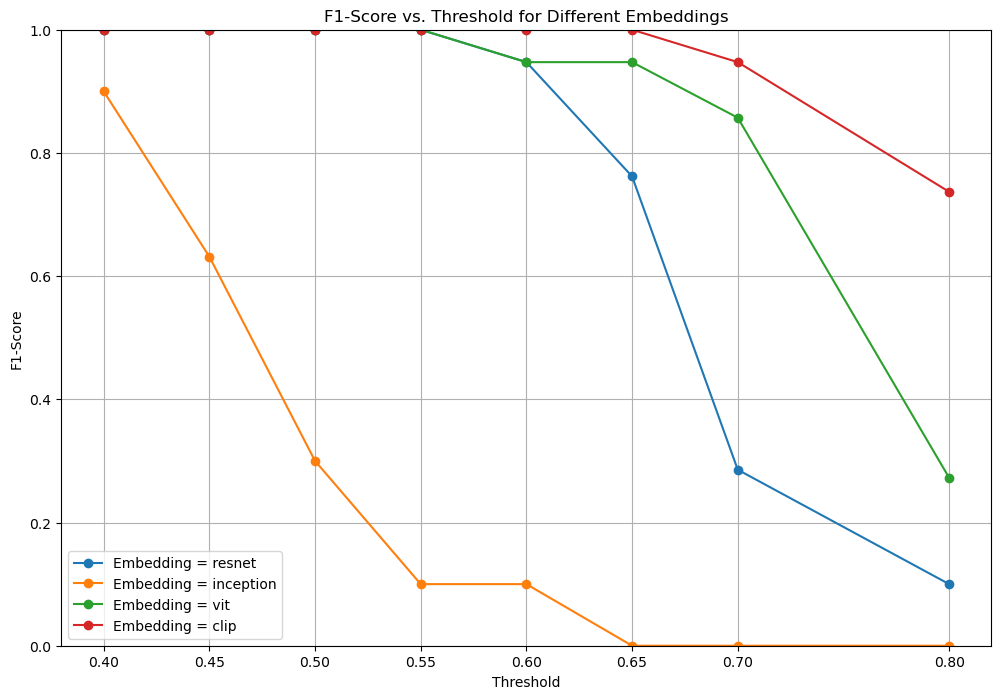

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Hàm tính Precision, Recall, F1-Score giữa hai danh sách các đoạn video
def calculate_f1_score(video1_embeddings, video2_embeddings, threshold=0.8):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Tính Cosine Similarity giữa từng đoạn của video tóm tắt và video ground truth
    for i, emb1 in enumerate(video1_embeddings):
        max_sim = 0
        for emb2 in video2_embeddings:
            cos_sim = cosine_similarity([emb1], [emb2])[0][0]
            if cos_sim > max_sim:
                max_sim = cos_sim

        # Đoạn có cosine similarity lớn hơn ngưỡng được coi là tương đồng
        if max_sim >= threshold:
            true_positives += 1
        else:
            false_positives += 1

    # False Negatives: Đoạn trong video ground truth mà không có đoạn tương ứng trong video tóm tắt
    for emb2 in video2_embeddings:
        max_sim = 0
        for emb1 in video1_embeddings:
            cos_sim = cosine_similarity([emb2], [emb1])[0][0]
            if cos_sim > max_sim:
                max_sim = cos_sim

        if max_sim < threshold:
            false_negatives += 1

    # Tính Precision, Recall và F1-Score
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

f1_scores_dict = {}
embeddings = ['resnet', 'inception', 'vit', 'clip']

# Các giá trị threshold
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8]
for embedding  in tqdm(embeddings):
    video1, video2 = [], []
    for i, j in tqdm(zip(sorted_gt, sorted_data)):
        video1_embedding, video2_embedding = get_video_embedding(f"{root_gt}/{i}", model_type = embedding ), get_video_embedding(f"{root_data}/{j}", model_type = embedding )
        video1.append(video1_embedding)
        video2.append(video2_embedding)

    f1_scores = []
    for threshold in tqdm(thresholds):
        _, _, f1_score = calculate_f1_score(video1, video2, threshold= threshold)
        f1_scores.append(f1_score)
    
    f1_scores_dict[embedding] = f1_scores
    

import matplotlib.pyplot as plt

# Dữ liệu cần vẽ
plt.figure(figsize=(12, 8))

for embedding in embeddings:
    plt.plot(thresholds, f1_scores_dict[embedding], marker='o', linestyle='-', label=f'Embedding = {embedding}')

plt.title('F1-Score vs. Threshold for Different Embeddings')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.grid(True)
plt.xticks(thresholds)
plt.legend()
plt.show()

    